In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig1")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
metric = "adc"
distribution_metric = "qfmean"
data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)

/tmp/ipykernel_1764211/1959349132.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [5]:
if metric == "gm_vol":
    data_global = data.drop_duplicates(subset=["subject_code"], keep="first")
else:
    data_global = data.groupby("subject_code").agg({distribution_metric: "mean","sex":"first","age_at_scan":"first"}).reset_index()

In [6]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [7]:
def assign_weights_by_population(
    data: pd.DataFrame,
    population_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    range_start: str = "range_start",
    range_end: str = "range_end",
    total: str = "total",
) -> np.ndarray:
    """
    Post-stratification weights so the age distribution of *data*
    matches an external reference.

    - Accepts integer or float ages.
    - Handles boundary ages (include_lowest=True).
    - Leaves bins with zero sample untouched (weight=0 → later dropped).
    - Returns weights whose mean == 1 across *non-zero* weights.
    """

    # 1. Make sure population bins are well-formed
    pop = (
        population_df[[range_start, range_end, total]]
        .sort_values(range_start)
        .reset_index(drop=True)
    )
    if (pop[range_end] <= pop[range_start]).any():
        raise ValueError("Each range_end must exceed range_start.")
    if (pop[range_start].iloc[1:].values < pop[range_end].iloc[:-1].values).any():
        raise ValueError("Age bins overlap or are not strictly increasing.")

    # 2. Bin edges for pd.cut  →  [..., last_end]  (right-inclusive)
    bin_edges = pop[range_start].tolist() + [pop[range_end].iloc[-1]]

    # Population proportions (works for % or counts)
    pop_prop = pop[total] / pop[total].sum()

    # 3. Assign each participant to a bin
    sample_bins = pd.cut(
        data[age_col],
        bins=bin_edges,
        right=True,            # include right edge
        include_lowest=True,   # include first left edge
        labels=pop.index,      # integer labels 0..n-1
    )

    # 4. Sample distribution
    sample_counts = sample_bins.value_counts(sort=False)
    sample_prop = sample_counts / sample_counts.sum()

    # 5. Weight lookup  (population / sample)  — careful with zeros
    weight_lookup = pop_prop / sample_prop.replace(0, np.nan)

    # 6. Map to rows; bins with zero sample → NaN weight → drop later
    w = sample_bins.map(weight_lookup).to_numpy()

    # Assign *zero* weight (instead of 1) to rows that were NaN
    w = np.where(np.isnan(w), 0.0, w)

    # 7. Rescale so mean(weight > 0) == 1
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    return w


In [8]:
import numpy as np
import pandas as pd

# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at  
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)         # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(
                pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values
            )[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,       # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)   # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)      # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),   # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w


In [9]:
age_df = israel_population.copy()
age_df["Population"] = "Population (ref.)"
snbb_age_df = age_df.copy()
snbb_age_df["Population"] = "SNBB"

# convert age_range to pd.IntervalIndex
age_df["age_range"] = pd.IntervalIndex.from_tuples(
    [(int(row["range_start"]), int(min(row["range_end"], 100))) for i, row in age_df.iterrows()]
)

# simulate ages for the reference population
n_sim = data_global["subject_code"].nunique()
bins = age_df["age_range"].to_numpy()
probs = age_df["total"].values

# How many samples to draw from each bin
np.random.seed(42)  # for reproducibility
counts = np.random.multinomial(n_sim, probs / probs.sum())
# Generate random ages based on the bin edges
# Generate synthetic ages: uniform within each bin
ages_sim = np.hstack(
    [
        np.random.uniform(low=iv.left, high=iv.right, size=c)
        for iv, c in zip(bins, counts)
    ]
)
age_df = pd.DataFrame({"age_at_scan": ages_sim})
age_df["Population"] = "Population (ref.)"


if metric == "gm_vol":
    snbb_age_df = data_global[["age_at_scan","sex","tiv","total_gm_volume","strip_score"]].copy()
else:
    snbb_age_df = data_global[["age_at_scan","sex",distribution_metric]].copy()
# snbb_age_df["weight"] = assign_weights_by_population(data=snbb_age_df, population_df=israel_population, age_col="age_at_scan")
snbb_age_df["weight"], bin_tbl = compute_poststrat_weights(
    snbb_age_df,
    israel_population,
    age_col="age_at_scan",
    cap=None,                # try None first; if still spiky, use 4 or 5
    return_bin_table=True
)
snbb_age_df["Population"] = "SNBB"

# age_df = pd.concat([age_df, snbb_age_df], ignore_index=True)

snbb_age_df["sex"] = snbb_age_df["sex"].map({"M": 0, "F": 1})

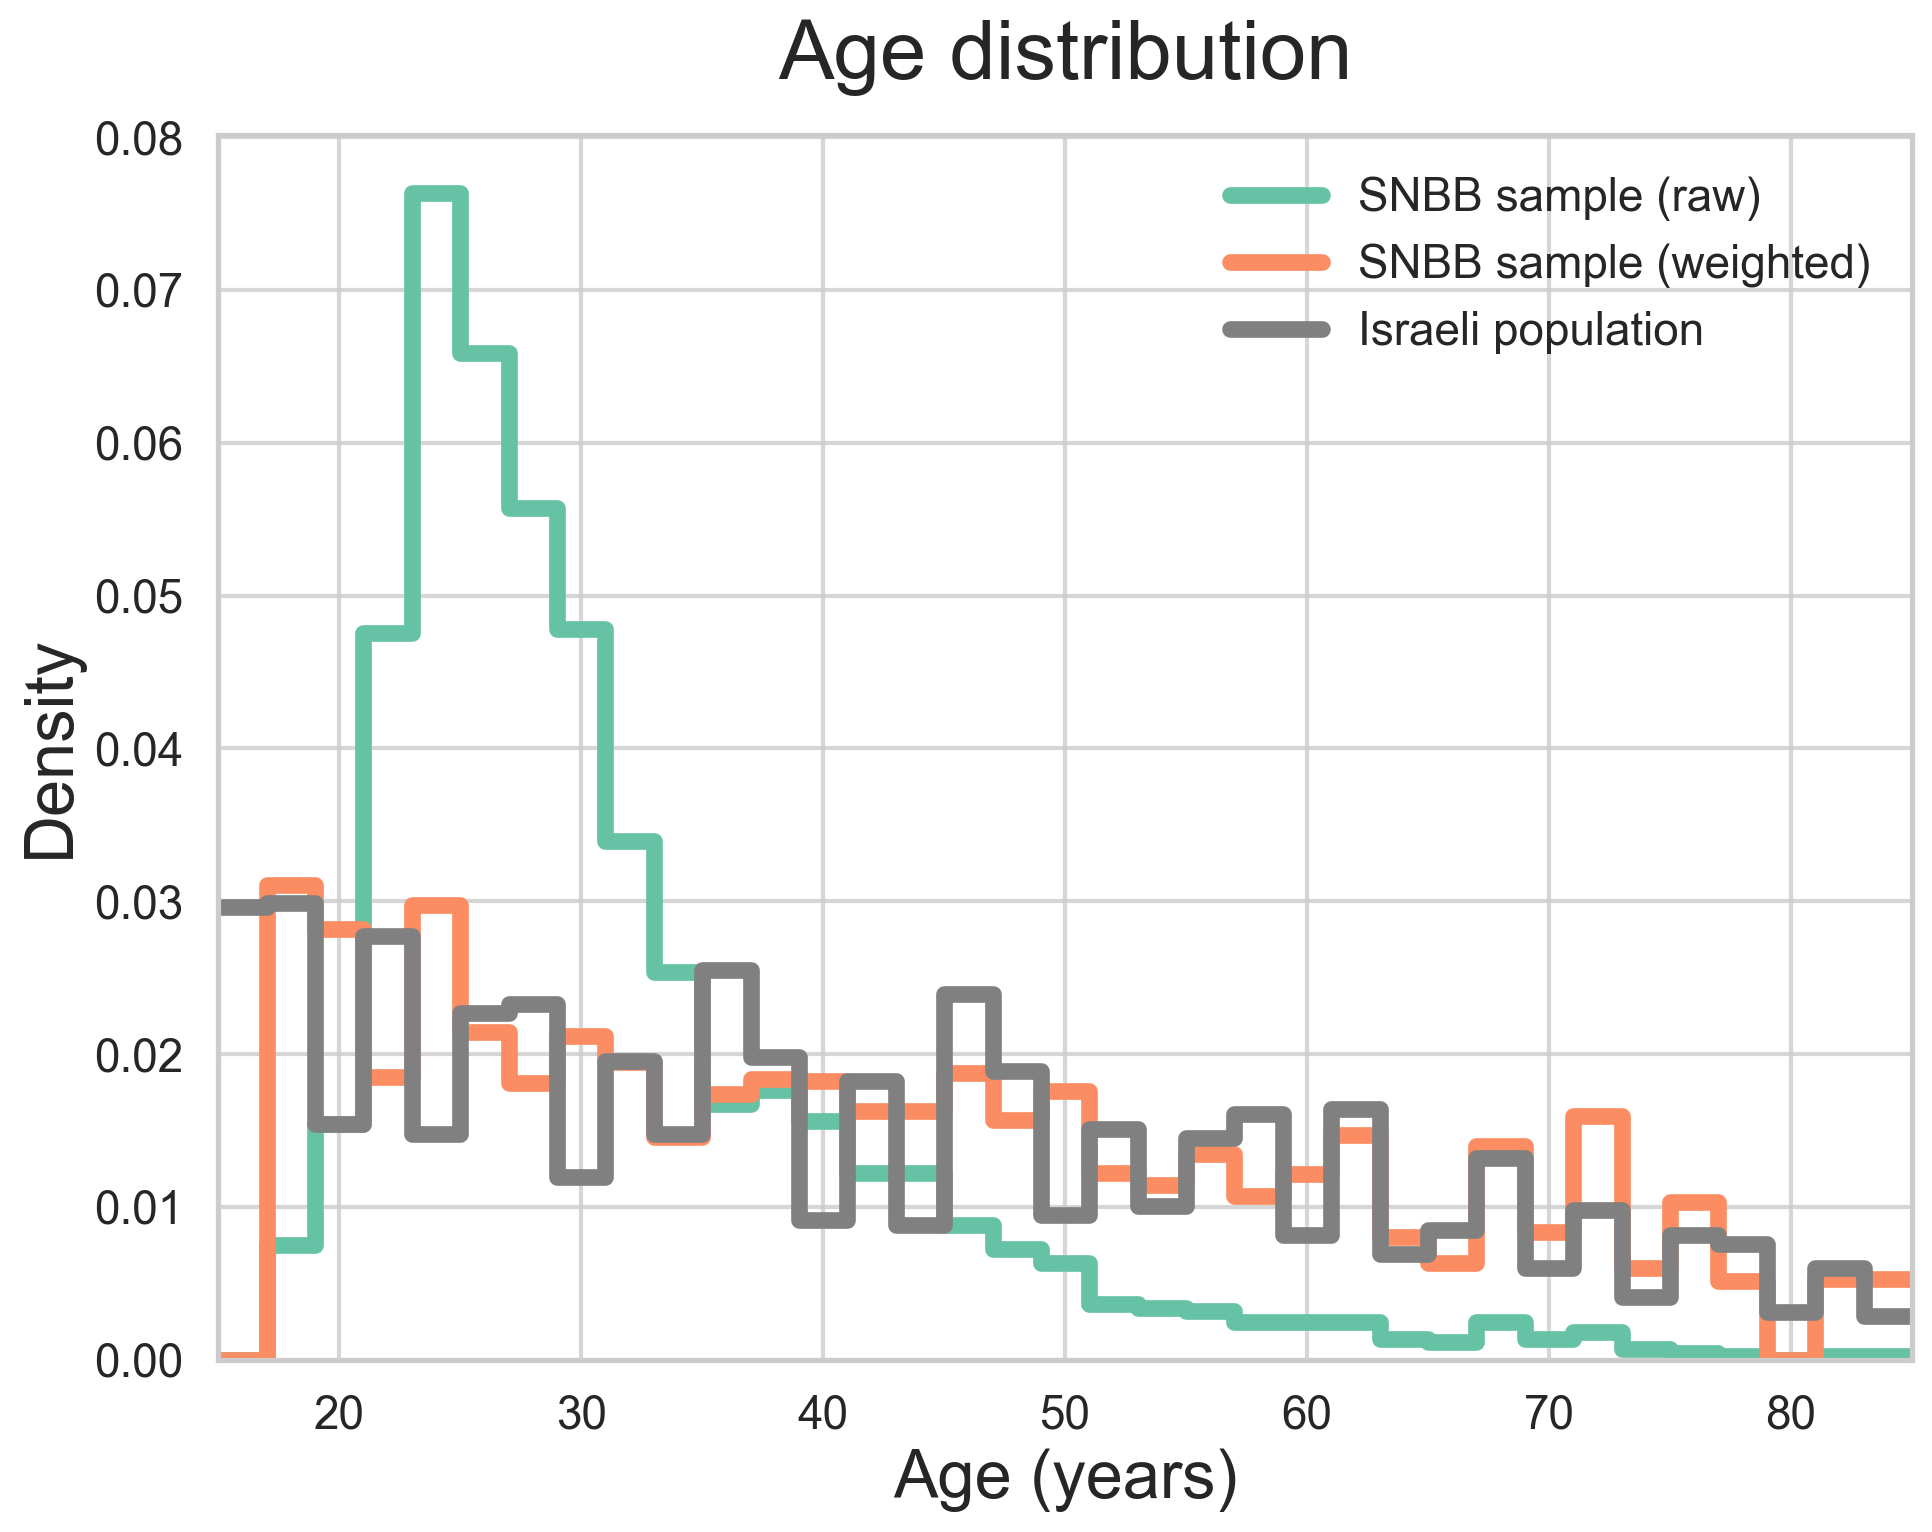

In [10]:
# ── Assumptions ────────────────────────────────────────────────────────────
# • age_df ........ Israeli population           (col: "age_at_scan")
# • snbb_age_df ... Study participants           (cols: "age_at_scan", "weight")
# • The global plotting config cell          has already been run
# • 'metric_col' is *one* brain metric to demo β-shift (e.g., "mean_diffusivity")
from statsmodels.formula.api import ols, wls
# mpl.rcParams.update({"axes.labelsize": 24})
# ── parameters you might tweak ─────────────────────────────────────────────
metric_col   = distribution_metric if metric != "gm_vol" else "total_gm_volume"      # exemplar column in snbb_age_df
covariates   = ["sex"] if metric != "gm_vol" else ["sex", "tiv"]         # extra cols in snbb_age_df to control
bin_width    = 2                      # years
age_min, age_max = 15, 85             # x-axis limits
line_width = 6
# ── figure canvas ─────────────────────────────────────────────────────────-
fig, ax = plt.subplots(figsize=(10,8))

# ─────────────────────── Panel A: Age distribution ────────────────────────
bins = list(np.arange(age_min, age_max + bin_width, bin_width))  # ←  LIST


# Raw sample
sns.histplot(
    snbb_age_df,
    x="age_at_scan",
    bins=bins,
    stat="density",
    element="step",
    fill=False,
    label="SNBB sample (raw)",
    linewidth=line_width,
    ax=ax
)
# Weighted sample
sns.histplot(
    snbb_age_df,
    x="age_at_scan",
    bins=bins,
    weights="weight",
    stat="density",
    element="step",
    fill=False,
    label="SNBB sample (weighted)",
    linewidth=line_width,
    ax=ax
)
# Population
sns.histplot(
    age_df,
    x="age_at_scan",
    bins=bins,
    stat="density",
    element="step",
    fill=False,
    color="grey",
    label="Israeli population",
    linewidth=line_width,
    ax=ax,
)


ax.set(
    xlabel="Age (years)", ylabel="Density",
    xlim=(age_min, age_max)
)
ax.set_title("Age distribution", fontsize=30,pad=20)
ax.set_ylabel("Density", fontsize=24)
ax.set_xlabel("Age (years)", fontsize=24)
ax.legend(frameon=False)

savefig_nice(
    fig,
    OUTPUT_DIR / "fig1a_age_distribution.png",
    tight=True,
    dpi=300,
)

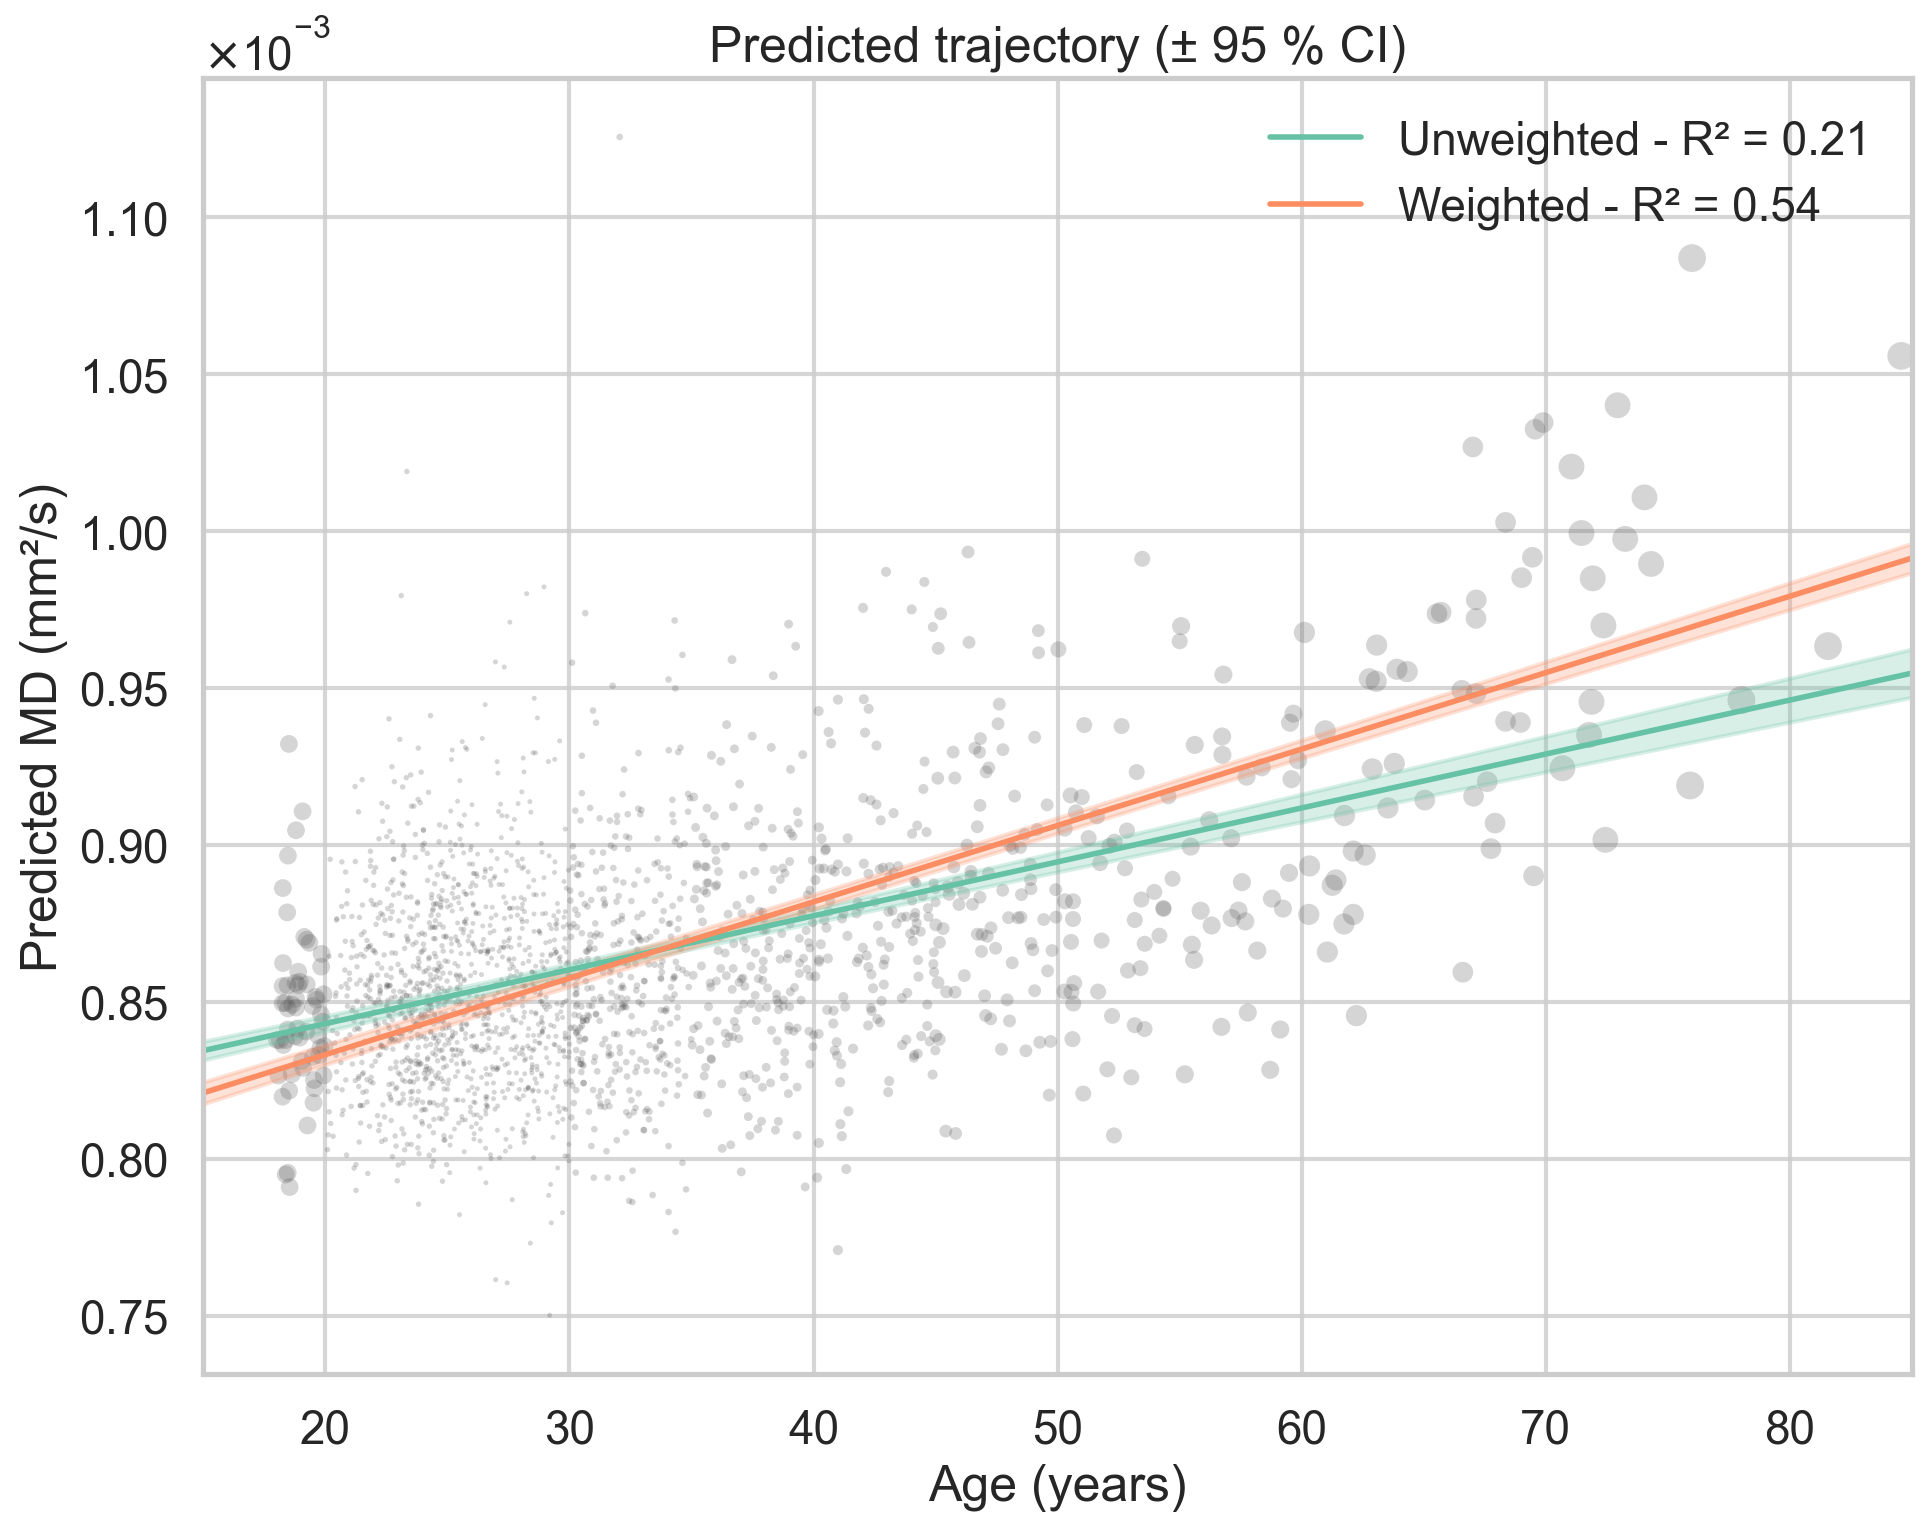

In [11]:



# ────────────────── Panel B: Predicted trajectory ± 95 % CI ──────────────

fig, ax = plt.subplots(figsize=(10, 8))

# 1. Choose model form
use_quadratic = False   # set True if age^2 belongs in this metric
formula_terms = ["age_at_scan", "I(age_at_scan**2)"] if use_quadratic else ["age_at_scan"]
controls      = covariates                                 # from earlier cell
terms         = formula_terms + controls
formula       = f"{metric_col} ~ " + " + ".join(terms)

# 2. Fit models
mod_unw = ols(formula, data=snbb_age_df).fit()
mod_w   = wls(formula, data=snbb_age_df, weights=snbb_age_df["weight"]).fit()

# 3. Prediction frame
age_grid = np.linspace(age_min, age_max, 300)
pred_df  = pd.DataFrame({ "age_at_scan": age_grid })
# fill static covariates with their median / mode
for cov in controls:
    if snbb_age_df[cov].dtype.kind in "bifc":      # numeric
        pred_df[cov] = snbb_age_df[cov].median()
    else:                                          # categorical
        pred_df[cov] = snbb_age_df[cov].mode()[0]

# 4. Get predictions & CI
for tag, model in [("Unweighted", mod_unw), ("Weighted", mod_w)]:
    pr  = model.get_prediction(pred_df)
    ci  = pr.conf_int(alpha=0.05)
    pred_df[f"{tag}_fit"] = pr.predicted_mean
    pred_df[f"{tag}_lo"]  = ci[:, 0]
    pred_df[f"{tag}_hi"]  = ci[:, 1]

# 5. Plot
ax.clear()  # reuse the same axes handle

# Background scatter (down-sample for speed / clarity)
sizes = np.clip(snbb_age_df["weight"] * 10, 0, 100)
sns.scatterplot(
    data=snbb_age_df,
    x="age_at_scan", y=metric_col,
    alpha=0.25, s=sizes, edgecolor="none", ax=ax, legend=False, color=COL_REF,
)

# # Fit lines & ribbons
for tag, color, model in zip(["Unweighted", "Weighted"], sns.color_palette("Set2", 2), [mod_unw, mod_w]):
    label = f"{tag} - R² = {model.rsquared:.2f}"
    ax.plot(age_grid, pred_df[f"{tag}_fit"], label=label, lw=2, color=color)
    ax.fill_between(
        age_grid,
        pred_df[f"{tag}_lo"],
        pred_df[f"{tag}_hi"],
        color=color,
        alpha=0.25,
    )

ax.ticklabel_format(
        style="sci", axis="y", scilimits=(0, 0), useMathText=True
    )
if metric == "gm_vol":
    ylabel = "Predicted GM Volume (mm³)"
    # set y axis format to cm instead of mm
else:
    ylabel = "Predicted MD (mm²/s)"

ax.set(
    xlabel="Age (years)",
    ylabel=ylabel,
    xlim=(age_min, age_max),
)
ax.set_title("Predicted trajectory (± 95 % CI)")
ax.legend(frameon=False)


model_type = "quad" if use_quadratic else "linear"
savefig_nice(
    fig,
    OUTPUT_DIR / f"fig1_{metric}_{model_type}.png",
    tight=True,
    dpi=300,
)



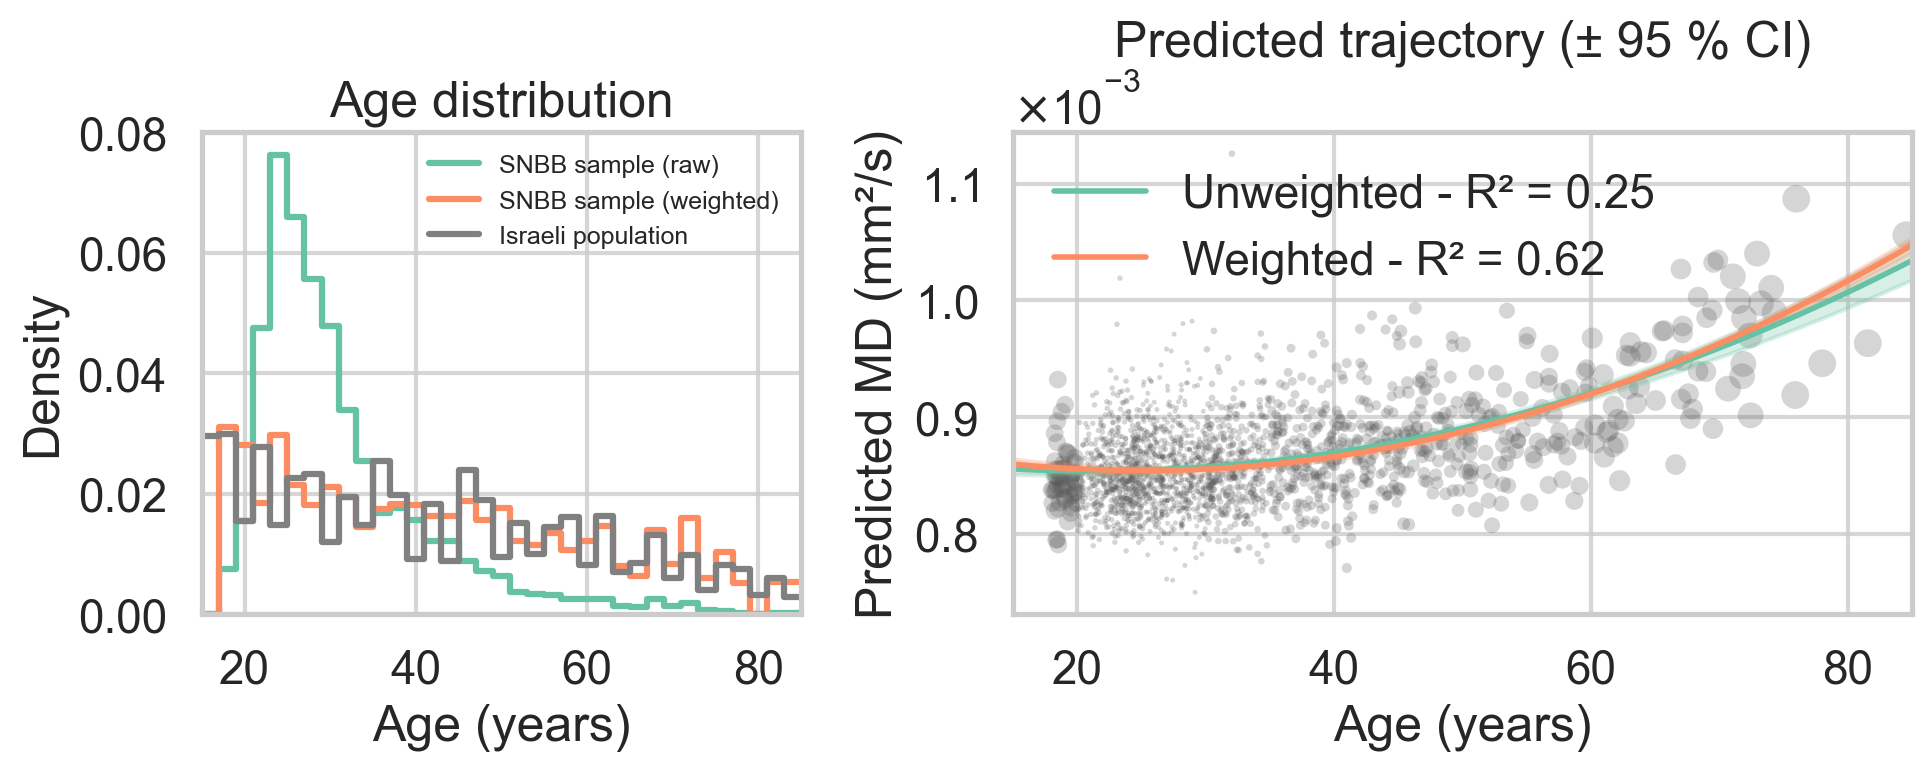

In [12]:
# ── Assumptions ────────────────────────────────────────────────────────────
# • age_df ........ Israeli population           (col: "age_at_scan")
# • snbb_age_df ... Study participants           (cols: "age_at_scan", "weight")
# • The global plotting config cell          has already been run
# • 'metric_col' is *one* brain metric to demo β-shift (e.g., "mean_diffusivity")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols, wls

# ── parameters you might tweak ─────────────────────────────────────────────
metric_col   = distribution_metric if metric != "gm_vol" else "total_gm_volume"      # exemplar column in snbb_age_df
covariates   = ["sex"] if metric != "gm_vol" else ["sex", "tiv"]         # extra cols in snbb_age_df to control
bin_width    = 2                      # years
age_min, age_max = 15, 85             # x-axis limits

# ── figure canvas ─────────────────────────────────────────────────────────-
fig, (axA, axB) = plt.subplots(
    1, 2, figsize=(10, 4.2), gridspec_kw={"width_ratios": [2, 3]}
)

# ─────────────────────── Panel A: Age distribution ────────────────────────
bins = list(np.arange(age_min, age_max + bin_width, bin_width))  # ←  LIST

# Raw sample
sns.histplot(
    snbb_age_df, x="age_at_scan", bins=bins, stat="density",
    element="step", fill=False, label="SNBB sample (raw)", ax=axA
)

# Weighted sample
sns.histplot(
    snbb_age_df, x="age_at_scan", bins=bins, weights="weight",
    stat="density", element="step", fill=False, label="SNBB sample (weighted)",
    ax=axA
)

# Population
sns.histplot(
    age_df, x="age_at_scan", bins=bins, stat="density",
    element="step", fill=False, color="grey", label="Israeli population",
    ax=axA
)

axA.set(
    xlabel="Age (years)", ylabel="Density",
    xlim=(age_min, age_max)
)
axA.set_title("Age distribution")
axA.legend(frameon=False, fontsize=9)



# ────────────────── Panel B: Predicted trajectory ± 95 % CI ──────────────

# 1. Choose model form
use_quadratic = True   # set True if age^2 belongs in this metric
formula_terms = ["age_at_scan", "I(age_at_scan**2)"] if use_quadratic else ["age_at_scan"]
controls      = covariates                                 # from earlier cell
terms         = formula_terms + controls
formula       = f"{metric_col} ~ " + " + ".join(terms)

# 2. Fit models
mod_unw = ols(formula, data=snbb_age_df).fit()
mod_w   = wls(formula, data=snbb_age_df, weights=snbb_age_df["weight"]).fit()

# 3. Prediction frame
age_grid = np.linspace(age_min, age_max, 300)
pred_df  = pd.DataFrame({ "age_at_scan": age_grid })
# fill static covariates with their median / mode
for cov in controls:
    if snbb_age_df[cov].dtype.kind in "bifc":      # numeric
        pred_df[cov] = snbb_age_df[cov].median()
    else:                                          # categorical
        pred_df[cov] = snbb_age_df[cov].mode()[0]

# 4. Get predictions & CI
for tag, model in [("Unweighted", mod_unw), ("Weighted", mod_w)]:
    pr  = model.get_prediction(pred_df)
    ci  = pr.conf_int(alpha=0.05)
    pred_df[f"{tag}_fit"] = pr.predicted_mean
    pred_df[f"{tag}_lo"]  = ci[:, 0]
    pred_df[f"{tag}_hi"]  = ci[:, 1]

# 5. Plot
axB.clear()  # reuse the same axes handle

# Background scatter (down-sample for speed / clarity)
sizes = np.clip(snbb_age_df["weight"] * 10, 0, 100)
sns.scatterplot(
    data=snbb_age_df,
    x="age_at_scan", y=metric_col,
    alpha=0.25, s=sizes, edgecolor="none", ax=axB, legend=False, color=COL_REF,
)

# # Fit lines & ribbons
for tag, color, model in zip(["Unweighted", "Weighted"], sns.color_palette("Set2", 2), [mod_unw, mod_w]):
    label = f"{tag} - R² = {model.rsquared:.2f}"
    axB.plot(age_grid, pred_df[f"{tag}_fit"], label=label, lw=2, color=color)
    axB.fill_between(
        age_grid,
        pred_df[f"{tag}_lo"],
        pred_df[f"{tag}_hi"],
        color=color,
        alpha=0.25,
    )

axB.ticklabel_format(
        style="sci", axis="y", scilimits=(0, 0), useMathText=True
    )
if metric == "gm_vol":
    ylabel = "Predicted GM Volume (mm³)"
    # set y axis format to cm instead of mm
else:
    ylabel = "Predicted MD (mm²/s)"

axB.set(
    xlabel="Age (years)",
    ylabel=ylabel,
    xlim=(age_min, age_max),
)
axB.set_title("Predicted trajectory (± 95 % CI)")
axB.legend(frameon=False)

# axB.set_ylim([-0.001,0.002])
model_type = "quad" if use_quadratic else "linear"
savefig_nice(
    fig,
    OUTPUT_DIR / f"fig1_{metric}_{model_type}.png",
    tight=True,
    dpi=300,
)

